In [20]:
import os
import shutil
import random
from tqdm import tqdm
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
from copy import deepcopy

import monai
from monai import transforms

from utils.utils import adjust_window, visualize, print_info

In [2]:
data_dict = {
    'image': '../data/ID_c9d6fdc6_ID_7f09be285d.nii.gz',
    'label': '../data/ID_c9d6fdc6_ID_7f09be285d-ich_seg.nii.gz'
}

In [23]:
# 数据读取
io_transform = transforms.LoadImaged(keys=["image", "label"])
data = io_transform(data_dict)
print_info(data)

image shape: torch.Size([512, 512, 38]), image type: <class 'monai.data.meta_tensor.MetaTensor'>
label shape: torch.Size([512, 512, 38]), label type: <class 'monai.data.meta_tensor.MetaTensor'>


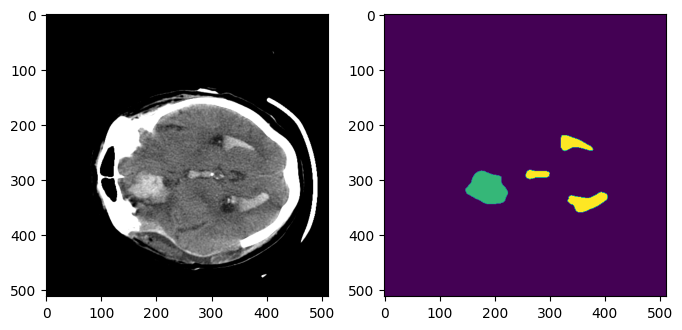

In [4]:
visualize(data)

In [24]:
# 添加channel维度
transform = transforms.EnsureChannelFirstd(keys=["image", "label"])
add_data = transform(data)
print_info(add_data)

image shape: torch.Size([1, 512, 512, 38]), image type: <class 'monai.data.meta_tensor.MetaTensor'>
label shape: torch.Size([1, 512, 512, 38]), label type: <class 'monai.data.meta_tensor.MetaTensor'>


## RandGaussianNoise

`RandGaussianNoised` 用于在图像中添加**高斯噪声（Gaussian noise）**，并且是**随机施加**的，目的是增强模型的鲁棒性。在输入数据上**以一定概率**添加**高斯噪声**，即：

$$
\text{noisy\_image} = \text{image} + \mathcal{N}(\mu, \sigma^2)
$$

### 使用场景 


- 提高模型对噪声的鲁棒性
- 模拟低质量成像设备或伪影

- 数据增强以缓解过拟合

### 参数解析 

| 参数名                   | 类型                 | 说明                                                         |
| ------------------------ | -------------------- | ------------------------------------------------------------ |
| **`keys`**               | `str` 或 `List[str]` | 要应用该变换的字典键。例如 `["image"]` 表示只对图像添加噪声。 |
| **`prob`**               | `float`              | 应用高斯噪声的概率。值为 0 到 1，默认是 0.1。                |
| **`mean`**               | `float`              | 高斯分布的均值 μ。默认是 0.0。                               |
| **`std`**                | `float`              | 高斯分布的标准差 σ。决定噪声的强度。                         |
| **`dtype`**              | `np.dtype` 或 `None` | 输出的数据类型，默认是 `np.float32`，设置为 `None` 则保持原输入类型。 |
| **`allow_missing_keys`** | `bool`               | 如果为 True，某些指定键缺失时不会报错。常用于不确定所有样本都包含特定键的情况。 |
| **`sample_std`**         | `bool`               | 若设为 `True`，则在 `[0, std]` 范围内**随机采样标准差 σ**，而不是固定使用 `std`。可提升数据多样性。 |

image shape: torch.Size([1, 512, 512, 38]), image type: <class 'monai.data.meta_tensor.MetaTensor'>
label shape: torch.Size([1, 512, 512, 38]), label type: <class 'monai.data.meta_tensor.MetaTensor'>


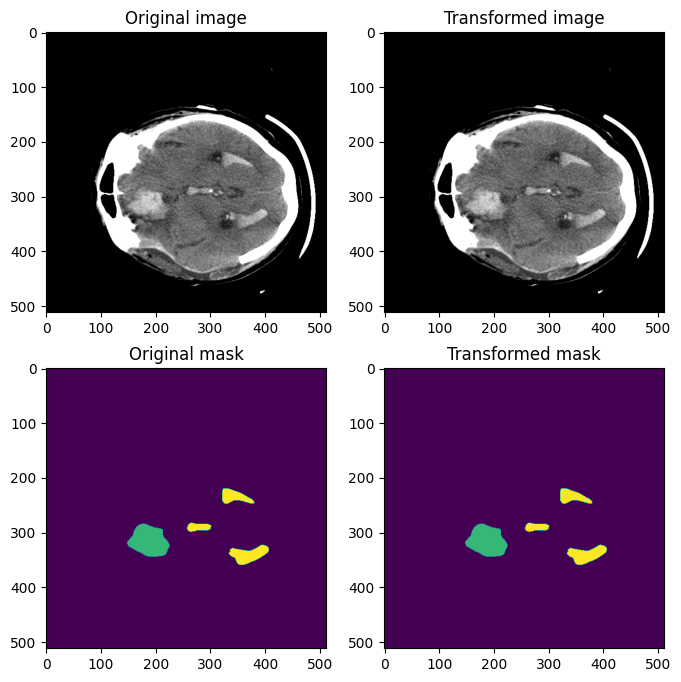

In [6]:
transform = transforms.RandGaussianNoised(
    keys=["image"],
    prob=1,
    mean=0,
    std=1
)
aug_data = transform(add_data)
print_info(aug_data)
visualize(data, aug_data)

## RandRicianNoise

`RandRicianNoised` 是一种用于医学图像数据增强的随机变换（transform），专门用来向图像中加入Rician噪声。这种噪声在MRI图像中非常常见，用于模拟现实中MRI采集过程中的噪声，帮助模型增强对真实世界数据的鲁棒性。

Rician噪声是复高斯噪声的模长分布，公式为：

$$
I_{\text{rician}} = \sqrt{(I + n_1)^2 + n_2^2}
$$

其中：

-   $I$ 是原始图像像素值

-   $n_1, n_2 \sim \mathcal{N}(0, \sigma^2)$，是两个独立的高斯噪声

### 使用场景 


- 提高模型泛化能力
- 模拟低信噪比（SNR）的图像

- 增强鲁棒性，特别是在多中心或多设备数据集训练中

### 参数解析 

| 参数名               | 类型                | 默认值  | 说明                                                         |
| -------------------- | ------------------- | ------- | ------------------------------------------------------------ |
| keys                 | str 或 list\[str\]  | 必需    | 要添加 Rician 噪声的字段键名，通常为 "image"。               |
| prob                 | float               | 0.1     | 添加 Rician 噪声的概率，范围 \[0, 1\]。                      |
| mean                 | float               | 0.0     | 构造噪声的高斯分布均值。通常设为 0。                         |
| std                  | float               | 0.05    | 高斯分布的标准差，控制噪声强度。                             |
| channel\_wise        | bool                | False   | 若为 True，则对每个通道单独添加噪声。                        |
| relative             | bool                | False   | 若为 True，则 std 表示图像或通道强度标准差的倍数。           |
| sample\_std          | bool                | False   | 若为 True，从区间 \[0, std\] 中随机采样当前样本的 std 值。   |
| dtype                | numpy.dtype 或 None | float32 | 输出图像的数据类型。如果为 None，则保持与输入数据类型一致。  |
| allow\_missing\_keys | bool                | False   | 若为 True，若数据中缺少某个 key 则不会报错。适用于部分字段可能缺失的情况。 |

image shape: torch.Size([1, 512, 512, 38]), image type: <class 'monai.data.meta_tensor.MetaTensor'>
label shape: torch.Size([1, 512, 512, 38]), label type: <class 'monai.data.meta_tensor.MetaTensor'>


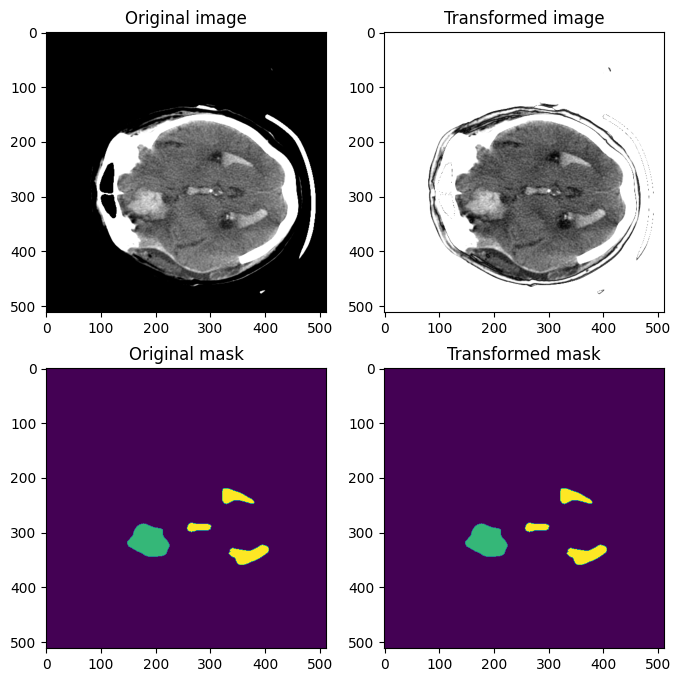

In [7]:
transform = transforms.RandRicianNoised(
    keys=["image"],
    prob=1,
    mean=0,
    std=1
)
aug_data = transform(add_data)
print_info(aug_data)
visualize(data, aug_data)

## RandShiftIntensity
Rand
`ShiftIntensityd` 用于对图像的像素强度值进行平移（shift）处理。它可以增加训练数据的多样性，提高模型的鲁棒性。该变换作用于图像像素值，将其加上一个偏移值，使图像亮度发生变化。

### 使用场景 

-   用于模拟不同成像条件下的亮度变化。

-   增强模型对于亮度/对比度变化的适应能力。

-   特别适用于 MRI、CT 等灰度图像。

### 参数解析 

| 参数名               | 类型                           | 默认值       | 说明                                                         |
| -------------------- | ------------------------------ | ------------ | ------------------------------------------------------------ |
| keys                 | str 或 Sequence\[str\]         | 无           | 指定要应用变换的数据字段名称，常用为 "
| prob                 | float               | 0.1     | 添加 Rician 噪声的概率，范围 \[0, 1\]。                      |image"，支持多个字段。 |
| offset               | float 或 Tuple\[float, float\] | 无           | 强度偏移值；如果为范围 (a, b)，则每次变换随机从该区间采样一个值并加到图像像素上。 |
| safe                 | bool                           | False        | 是否在像素值溢出时进行安全裁剪。例如当数据类型为 uint8 时，255+1 结果会变为 255，而不是溢出成 0。 |
| factor\_key          | str 或 Sequence\[str\]         | None         | 若提供该参数，则 offset 会乘以从 metadata 中提取的 factor 值（如图像均值），以实现动态强度平移。通常和 IntensityStatsd 搭配使用。 |
| meta\_keys           | str 或 Sequence\[str\]         | None         | 显式指定用于提取 factor\_key 的 metadata 字典键（如 "image\_meta\_dict"）。若不指定，会由 key 和 meta\_key\_postfix 拼接得出。 |
| meta\_key\_postfix   | str                            | "meta\_dict" | 若未设置 meta\_keys，将使用 key + meta\_key\_postfix 构造 metadata 的键名（如 "image" ⇒ "image\_meta\_dict"）。 |
| allow\_missing\_keys | bool                           | False        | 若为 True，则当指定的 key 不存在时不会抛出异常。适用于处理不规则数据批次或多输入结构。 |

image shape: torch.Size([1, 512, 512, 38]), image type: <class 'monai.data.meta_tensor.MetaTensor'>
label shape: torch.Size([1, 512, 512, 38]), label type: <class 'monai.data.meta_tensor.MetaTensor'>


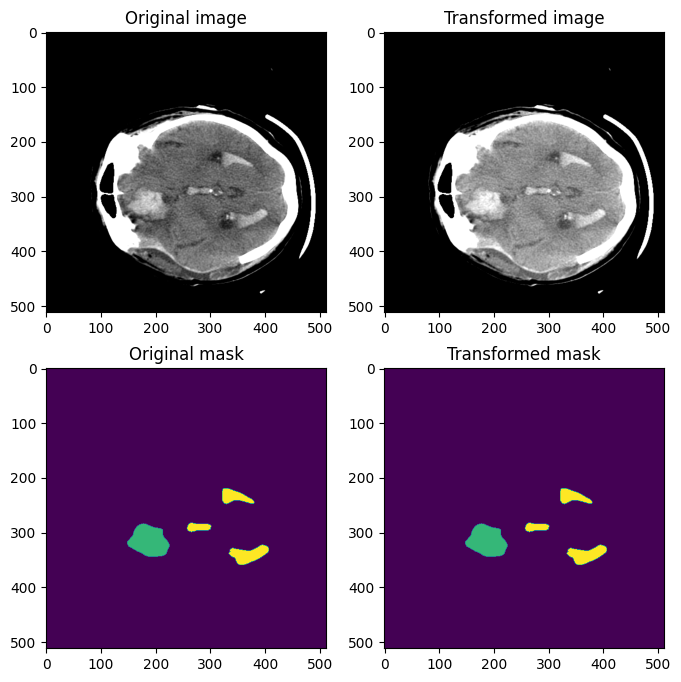

In [8]:
 transform = transforms.RandShiftIntensityd(
     keys=["image"],
     offsets=[10, 20],
     prob=1
 )
aug_data = transform(add_data)
print_info(aug_data)
visualize(data, aug_data)

## RandStdShiftIntensity

`RandStdShiftIntensityd` 用于改变图像的强度值（intensity），特别适合医学图像处理中做亮度/对比度扰动，增加模型的鲁棒性。

### 使用场景 

-   用于模拟不同成像条件下的亮度变化。

-   增强模型对于亮度/对比度变化的适应能力。

-   特别适用于 MRI、CT 等灰度图像。

### 参数解析 

| 参数名               | 说明                                                         | 备注                                |
| -------------------- | ------------------------------------------------------------ | ----------------------------------- |
| `keys`               | 要变换的字典键（key），指定应用变换的字段名称                | 例如 `["image"]`                    |
| `factors`            | 控制扰动幅度。若是元组，随机选取范围 `(min(factors), max(factors))`； | 用于乘以图像的标准差，生成偏移量    |
| `prob`               | 变换应用概率，范围 `[0,1]`                                   | 如 `0.1` 表示 10% 概率应用          |
| `nonzero`            | 是否只基于非零像素计算标准差                                 | `True` 时忽略零值（背景）像素       |
| `channel_wise`       | 是否对每个通道单独计算标准差                                 | `True` 时每通道分别扰动             |
| `dtype`              | 输出数据类型                                                 | 默认 `float32`；`None` 保持输入类型 |
| `allow_missing_keys` | 是否允许字典中缺失指定的 keys 而不抛异常                     | 防止因缺键导致程序崩溃              |

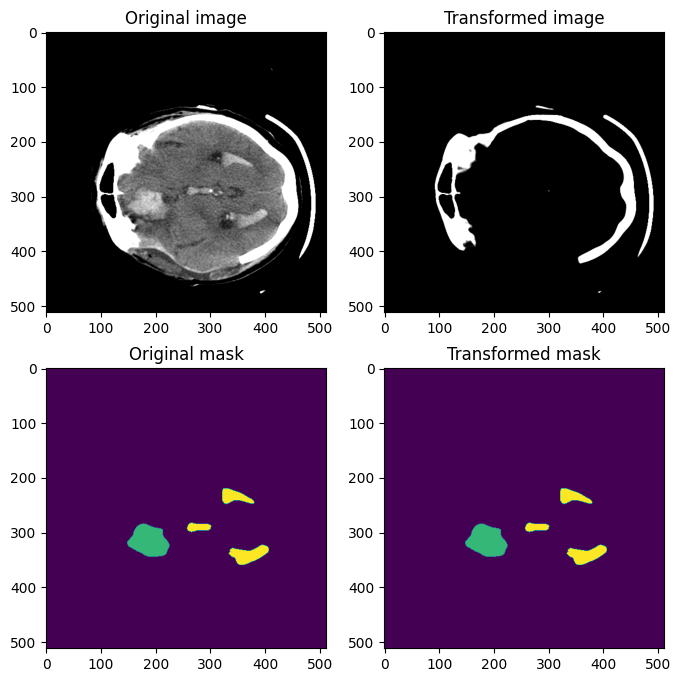

In [25]:
transform = transforms.RandStdShiftIntensityd(
    keys="image", 
    factors=0.2, 
    prob=1
)
add_data_tmp = deepcopy(add_data)
aug_data = transform(add_data_tmp)
visualize(data, aug_data)

## RandScaleIntensity

 `RandScaleIntensityd` 用于医学图像的强度归一化和增强，提升模型对图像亮度或对比度变化的鲁棒性。

### 使用场景 

-   用于模拟不同成像条件下的亮度变化。

-   增强模型对于亮度/对比度变化的适应能力。

-   特别适用于 MRI、CT 等灰度图像。

### 参数解析 

| 参数名               | 类型             | 默认值            | 说明                                                         |
| -------------------- | ---------------- | ----------------- | ------------------------------------------------------------ |
| `keys`               | list of str      | 必填              | 需要被变换的字典键名列表，如 `"image"`。                     |
| `factors`            | float 或 tuple   | (0.9, 1.1) 或单数 | 缩放因子的范围，变换计算为 `v = v * (1 + factor)`。单数时从 (-factors, factors) 采样。 |
| `prob`               | float            | 0.1               | 执行缩放变换的概率。10% 的概率应用。                         |
| `channel_wise`       | bool             | False             | 是否对每个通道分别随机缩放。需要保证输入图像第一个维度是通道。 |
| `dtype`              | 数据类型 或 None | float32           | 输出图像的数据类型。默认转为 `float32`。                     |
| `allow_missing_keys` | bool             | False             | 当字典中缺少指定键时，是否忽略并跳过，而非抛出异常。         |

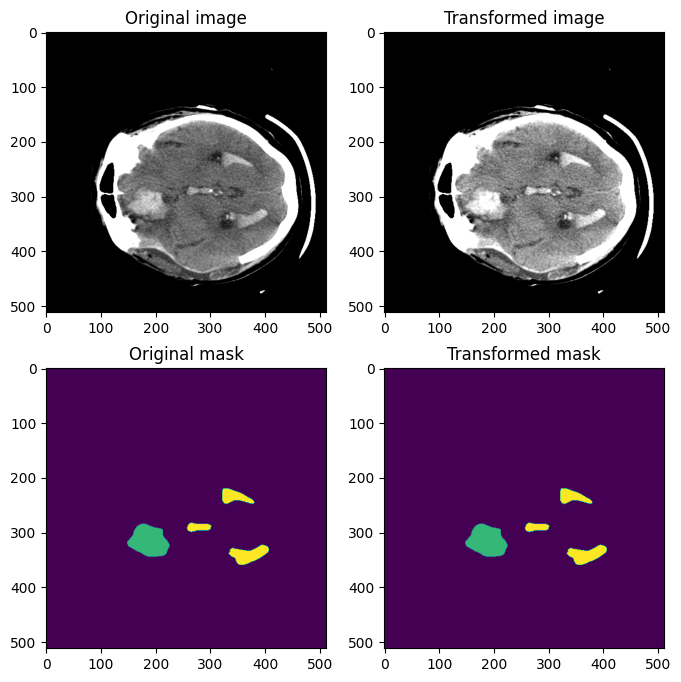

In [11]:
# v = v * (1 + factor)
transform = transforms.RandScaleIntensityd(
    keys="image", 
    factors=(0.3, 0.5), 
    prob=1
)
aug_data = transform(add_data)
visualize(data, aug_data)

## RandScaleIntensityFixedMean

`RandScaleIntensityFixedMeand`作用是对输入图像的像素值进行随机尺度缩放，但保持图像的均值固定，从而模拟不同的图像强度分布，增加模型的鲁棒性。

### 使用场景 

-   医学图像训练中模拟图像强度的随机变化，但保持图像整体亮度一致，防止模型过拟合于特定强度分布。

-   数据集图像亮度均值差异不大时，适用此变换以增加数据多样性。

-   适合CT、MRI等灰度图像的预处理。

### 参数解析 

| 参数名               | 类型              | 说明                                                         | 默认值 / 备注   |
| -------------------- | ----------------- | ------------------------------------------------------------ | --------------- |
| `keys`               | List\[str\]       | 需要变换的字典键名，指定要变换的图像数据字段                 | 无，必须指定    |
| `factors`            | float or tuple    | 缩放因子范围，采样的`factor`用于计算变换：`v = v * (1 + factor)`，若为单个数字，则采样范围为`(-factors, factors)` | 无，必须指定    |
| `preserve_range`     | bool              | 是否将输出裁剪回输入的数值范围，防止数值溢出                 | `False`         |
| `fixed_mean`         | bool              | 是否保持图像均值不变：先减均值，再缩放，最后加回均值         | `True`          |
| `channel_wise`       | bool              | 是否对每个通道单独缩放和保持均值，适用于多通道图像           | `False`         |
| `dtype`              | torch.dtype或None | 输出数据类型，默认`float32`，`None`表示保持输入类型          | `torch.float32` |
| `allow_missing_keys` | bool              | 是否允许输入字典中缺少指定`keys`时不报错                     | `False`         |

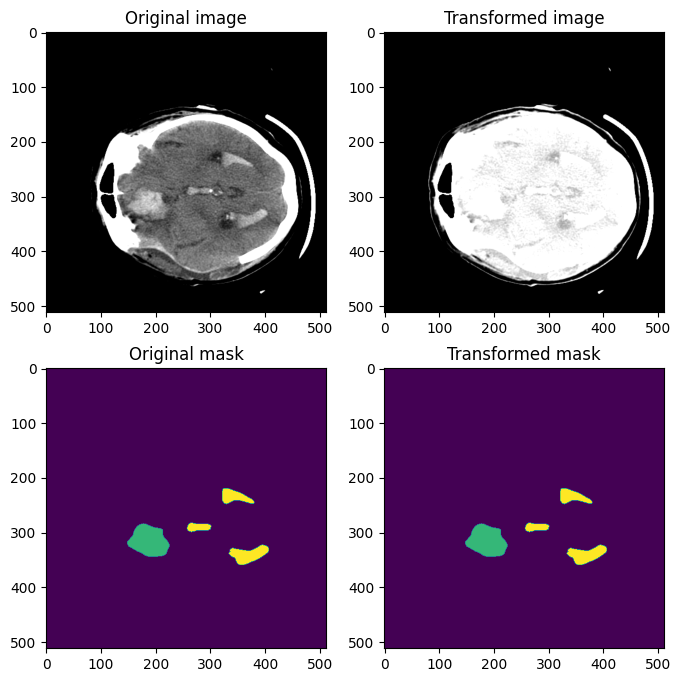

In [26]:
# v = v - mean(v)
# v = v * (1 + factor) + mean(v)
transform = transforms.RandScaleIntensityFixedMeand(
    keys="image",
    factors=0.2,
    fixed_mean=True,
    prob=1
)
aug_data = transform(add_data)
visualize(data, aug_data)

## RandBiasField

`RandBiasFieldd` 主要模拟MRI图像中常见的偏场效应（bias field），即图像亮度非均匀性的伪影。通过随机生成一个低频的乘性场（bias field）叠加到图像上，可以增加模型对实际图像中亮度不均匀情况的鲁棒性。

### 使用场景 

-   给输入的图像增加随机生成的偏场伪影，从而模拟真实MRI中亮度非均匀性。

### 参数解析 

| 参数名        | 含义                                                         | 默认值       |
| ------------- | ------------------------------------------------------------ | ------------ |
| `keys`        | 要进行增强的字段名称列表，通常是图像的key                    | `["image"]`  |
| `coeff_range` | 多项式系数的取值范围，决定偏场的强度和形态，长度3的tuple，如 `(0.1, 0.5)` | `(0.1, 0.5)` |
| `order`       | 多项式拟合的阶数，默认为3，阶数越高偏场越复杂                | `3`          |
| `mode`        | 插值方式，通常使用 `"bilinear"`                              | `"bilinear"` |
| `prob`        | 该变换被应用的概率                                           | `0.1`        |
| `device`      | 计算设备，如`"cpu"`或`"cuda"`                                | `None`       |



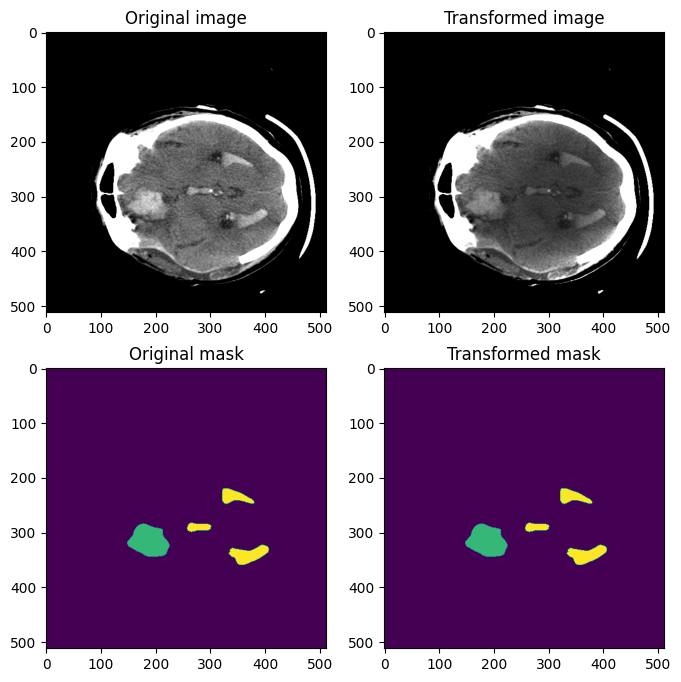

In [28]:
transform = transforms.RandBiasFieldd(
    keys="image",
    degree=3,
    coeff_range=(0.7, 1),
    prob=1
)
aug_data = transform(add_data)
visualize(data, aug_data)

## NormalizeIntensity

`NormalizeIntensityd` 是一种常用的基于字典的变换（dictionary-based transform），主要用于对图像数据进行强度归一化处理。

### 使用场景 

-   归一化后的图像数据能帮助深度学习模型更快收敛，减少强度值范围差异带来的影响。

### 参数解析 

| 参数名               | 说明                                                         | 默认值             |
| -------------------- | ------------------------------------------------------------ | ------------------ |
| `keys`               | 需要进行变换的字典键名列表，指定要归一化的图像字段。参考 `monai.transforms.MapTransform` | 必填               |
| `subtrahend`         | 减去的数值，通常是均值，用于归一化前减去该值                 | 无（默认自动计算） |
| `divisor`            | 除以的数值，通常是标准差，用于归一化时除以该值               | 无（默认自动计算） |
| `nonzero`            | 是否只对非零值进行归一化，常用于忽略背景0的像素              | False              |
| `channel_wise`       | 是否对每个通道单独计算均值和标准差，True则分通道计算，False则整体计算 | False              |
| `dtype`              | 输出数据类型，如果为 None，则和输入数据类型相同；默认转换为 `float32` | `float32`          |
| `allow_missing_keys` | 如果指定的 key 不存在，是否允许跳过该 key 不抛出异常         | False              |

image mean: -0.00, image std: 1.00


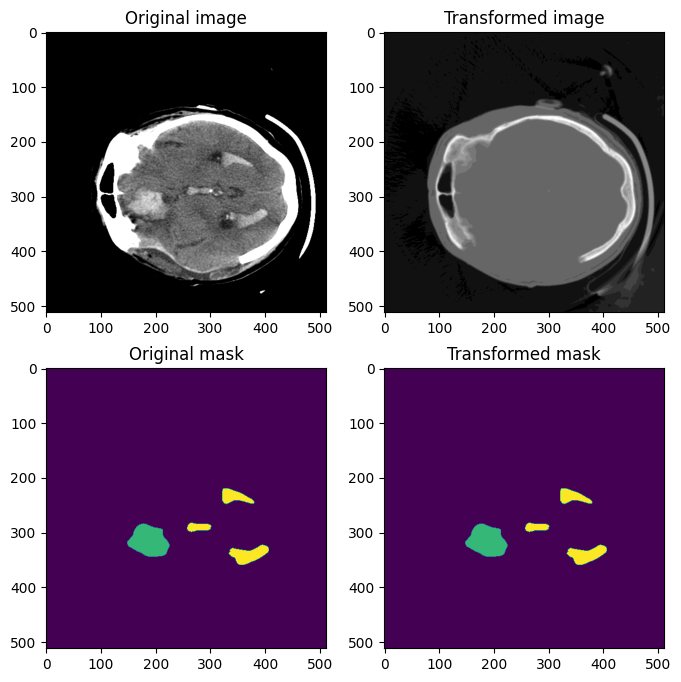

In [31]:
transform = transforms.NormalizeIntensityd(
    keys="image"
)
aug_data = transform(add_data)
print(f"image mean: {aug_data['image'].mean():.2f}, image std: {aug_data['image'].std():.2f}")
visualize(data, aug_data)